# Мегалайн

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Цель**

    В вашем распоряжении данные о поведении клиентов, которые уже
    перешли на эти тарифы (из проекта курса «Статистический анализ
    данных»). Нужно построить модель для задачи классификации, 
    которая выберет подходящий тариф. Предобработка данных не 
    понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.


## Инструкция по выполнению проекта

    1. Откройте файл с данными и изучите его. Путь к файлу: datasets/users_behavior.csv. Скачать датасет
    2. Разделите исходные данные на обучающую, валидационную и тестовую выборки.
    3. Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.
    4. Проверьте качество модели на тестовой выборке.
    5. Дополнительное задание: проверьте модели на вменяемость. Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше. В следующем курсе подробнее об этом расскажем.


## 1. Открывавем и и изучаем файл.

In [ ]:
# Импортируем библиотеки pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# И все используемое далее
from joblib import dump
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Убираем длинные циферки
#pd.set_option('display.float_format', '{:,.2f}'.format)
Отключаем лишние предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Читаем файл с данными и сохраняем в df
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    ! gdown --id 1yWWxa1jk9vdaK2eKWm2U602wu1bz7S8u
    df = pd.read_csv('/content/users_behavior.csv')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1yWWxa1jk9vdaK2eKWm2U602wu1bz7S8u
To: /content/users_behavior.csv
100% 134k/134k [00:00<00:00, 74.7MB/s]


### Таблица данных

In [ ]:
# Смотрим табличку
display(df.columns)
print()
display(df)

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


### Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

    • сalls — количество звонков,
    • minutes — суммарная длительность звонков в минутах,
    • messages — количество sms-сообщений,
    • mb_used — израсходованный интернет-трафик в Мб,
    • is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


### Инфо. Пропуски. Describe.

In [ ]:
# Посмотрим заполненость таблицы
print()
print('Инфо:')
print(df.info())                              # сколько значений и в каком формате
print()
print('Пропусков:')
print(df.isna().mean())                       # подсчёт пропусков в долях
print()
print('describe:')
display(df.describe())                        # вдруг чего "на глазок" проявится 
print()
print('Дубликатов =', df.duplicated().sum())  # проверим дубликаты


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None

Пропусков:
calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

describe:


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000



Дубликатов = 0


##### Вывод

- Количество записей 3214.
- Пропусков данных нет.
- Дубликатов не имеется.

## 2. Обучающая, валидационная и тестовая выборки.

In [ ]:
# Делим табличку на тренировочную (60%), валидационную (20%) и тестовую (20%)
features = df.drop(['is_ultra'], axis=1)
# будем прогнозировать тариф
target = df['is_ultra']
# отделяем 20% данных для тестовой выборки
features_train, features_test, target_train, target_test = train_test_split(
                                                                features, target, 
                                                                test_size=0.20, 
                                                                random_state=12345)
# отделяем 20% данных для валидационной выборки
features_train, features_valid, target_train, target_valid = train_test_split(
                                                                features_train, target_train, 
                                                                test_size=0.25, 
                                                                random_state=12345)

## 3. Качество разных моделей.

In [ ]:
# Решающее дерево
best_model_dt_c = None
best_result_dt_c = 0
# значимым количеством ответов считаем не менее 1% от общего количества ответов
msl = np.ceil(len(df['is_ultra']) / 100)
print("msl =", msl)
for depth in range(1, 100):                   # определяем лучшую глубину дерева
    model_dt_c = DecisionTreeClassifier(random_state=12345, 
                                        max_depth=depth, 
                                        min_samples_leaf=33)
    model_dt_c.fit(features_train, 
                   target_train)
    predictions = model_dt_c.predict(features_valid)
    result = accuracy_score(target_valid, 
                            predictions)      # считаем качество модели
    if result > best_result_dt_c:
        best_depth_dt_c_val = depth
        best_model_dt_c_val = model_dt_c
        best_result_dt_c = result
result_dt_c_val = best_result_dt_c
print()
print("Точность лучшей модели `Решающее дерево`:", result_dt_c_val)
print("Лучшая модель:", best_model_dt_c_val)

# Случайный лес
best_model_rf_c = None
best_result_rf_c = 0
for est in range(1, 100):                     # количество деревьев 100
    model_rf_c = RandomForestClassifier(random_state=12345, 
                                        n_estimators=est)
    model_rf_c.fit(features_train, 
              target_train)
    # считаем качество модели на валидационной выборке
    result = model_rf_c.score(features_valid, target_valid)
    if result > best_result_rf_c:
        best_est_rf_c_val = est
        best_model_rf_c_val = model_rf_c      # сохраняем наилучшую модель
        best_result_rf_c = result             # сохраняем наилучшее accuracy на валидационных данных
result_rf_c_val = best_result_rf_c
print()
print("Точность наилучшей модели `Случайный лес`:", result_rf_c_val)
print("Лучшая модель:", best_model_rf_c_val)


# Логистическая регрессия
best_model_log_r = None
best_result_log_r = 0
max_iter = 3
for iter in range(1, 100):                    # проверял до 500
    model_log_r = LogisticRegression(random_state=12345, 
                                     solver='lbfgs', 
                                     max_iter=iter)
    model_log_r.fit(features_train, 
                    target_train)
    # считаем значение метрики accuracy на валидационной выборке
    result = model_log_r.score(features_valid, 
                               target_valid)
    if result > best_result_log_r:
        best_model_log_r = model_log_r
        best_result_log_r = result
        best_iter_log_r_val = iter
result_log_r_val = best_result_log_r
print()
print("Точность логистической регрессии:", result_log_r_val)
print("Лучшее количество итераций логистической регрессии:", best_iter_log_r_val)


msl = 33.0

Точность лучшей модели `Решающее дерево`: 0.7682737169517885
Лучшая модель: DecisionTreeClassifier(max_depth=5, min_samples_leaf=33, random_state=12345)

Точность наилучшей модели `Случайный лес`: 0.7993779160186625
Лучшая модель: RandomForestClassifier(n_estimators=65, random_state=12345)

Точность логистической регрессии: 0.7371695178849145
Лучшее количество итераций логистической регрессии: 64


##### Вывод

    Модели можно отранжировать по точности предсказания:

        1.   Случайный лес
        2.   Решающее дерево
        3.   Логистическая регрессия



In [ ]:
# Убеждаемся, что модели регрессии можно не рассматривать

# Считаем RMSE
predictions = pd.Series(target.mean(), 
                        index=target.index)
mse = mean_squared_error(target, 
                         predictions)
rmse = mse** (0.5)
print()
print("RMSE:", rmse)

# Дерево решений в регрессии
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 10):
    model_dt_r = DecisionTreeRegressor(random_state=12345, 
                                       max_depth=depth)
    model_dt_r.fit(features_train, 
                   target_train)
    predictions_valid = model_dt_r.predict(features_valid)
    # считаем значение метрики rmse на валидационной выборке
    result = (mean_squared_error(target_valid, 
                                 predictions_valid)
                                 )** (0.5)
    if result < best_result:
        best_model = model_dt_r
        best_result = result
        best_depth = depth
result_dt_r = best_result
print()
print("RMSE наилучшей модели `Дерева решений`:", result_dt_r)
print("Глубина дерева:", best_depth)

# Случайный лес в регрессии
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
# с количеством деревьев: от 1 до 50 с шагом 2
for est in range(1, 51, 2):
    # с максимальной глубиной от 1 до 10
    for depth in range (1, 10):
        model_rf_r = RandomForestRegressor(random_state=12345, 
                                           n_estimators=est, 
                                           max_depth=depth)
        model_rf_r.fit(features_train, 
                       target_train)
        predictions_valid = model_rf_r.predict(features_valid)
        # считаем значение метрики rmse на валидационной выборке
        result = (mean_squared_error(target_valid, predictions_valid))** (0.5)
        if result < best_result:
            best_model = model_rf_r
            best_result = result
            best_est = est
            best_depth = depth
result_rf_r = best_result
print()
print("RMSE наилучшей модели `Случайный лес`:", result_rf_r)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", depth)

# Линейная регрессия
model_lin_r = LinearRegression()
model_lin_r.fit(features_train, 
                target_train)
predictions_valid = model_lin_r.predict(features_valid)
# считаем значение метрики RMSE на валидационной выборке
result_lin_r = (mean_squared_error(target_valid, predictions_valid))** (0.5)
print()
print("RMSE модели линейной регрессии:", result_lin_r)



RMSE: 0.46102797293043907

RMSE наилучшей модели `Дерева решений`: 0.42245705210925333
Глубина дерева: 3

RMSE наилучшей модели `Случайный лес`: 0.39711818050869907
Количество деревьев: 49
Максимальная глубина: 9

RMSE модели линейной регрессии: 0.4441344962964775


## 4. Качество модели на тестовой выборке.

In [ ]:
# Решающее дерево
model_dt_c_opt = DecisionTreeClassifier(random_state=12345, 
                                        max_depth=best_depth_dt_c_val, 
                                        min_samples_leaf=33)
model_dt_c.fit(features_train, 
               target_train)
predictions = model_dt_c.predict(features_test)
result = accuracy_score(target_test, 
                        predictions)
result_dt_c_test_opt = result

# А лучшие ли настройки были для тестовой выборки?
best_model_dt_c = None
best_result_dt_c = 0
for depth in range(1, 100): # определяем лучшую глубину дерева
    model_dt_c = DecisionTreeClassifier(random_state=12345, 
                                        max_depth=depth, 
                                        min_samples_leaf=33)
    model_dt_c.fit(features_train, 
                   target_train)
    predictions = model_dt_c.predict(features_test)
    result = accuracy_score(target_test, 
                            predictions) # считаем качество модели
    if result > best_result_dt_c:
        best_model_dt_c_test = model_dt_c
        best_result_dt_c = result
result_dt_c_test = best_result_dt_c
print()
print("Точность оптимизированная по лучшей валидационной модели `Решающее дерево`:", result_dt_c_test_opt)
print("Точность лучшей модели `Решающее дерево` на тестовой выборке:", result_dt_c_test)
print("Лучшая модель:", best_model_dt_c_test)

# Случайный лес
model_rf_c = RandomForestClassifier(random_state=12345, 
                                    n_estimators=best_est_rf_c_val)
model_rf_c.fit(features_train, 
               target_train)
result = model_rf_c.score(features_test, 
                          target_test)
result_rf_c_test_opt = result

# А лучшие ли настройки были для тестовой выборки?
best_model_rf_c = None
best_result_rf_c = 0
for est in range(1, 100): # количество деревьев 100
    model_rf_c = RandomForestClassifier(random_state=12345, 
                                        n_estimators=est)
    model_rf_c.fit(features_train, 
                   target_train)
    result = model_rf_c.score(features_test, 
                              target_test)
    if result > best_result_rf_c:
        best_model_rf_c_test = model_rf_c # сохраняем наилучшую модель
        best_result_rf_c = result #  сохраняем наилучшее accuracy на валидационных данных
result_rf_c_test = best_result_rf_c
print()
print("Точность оптимизированная по лучшей валидационной модели `Случайный лес`:", result_dt_c_test_opt)
print("Точность лучшей модели `Случайный лес` на тестовой выборке:", result_rf_c_test)
print("Лучшая модель:", best_model_rf_c_test)


# Логистическая регрессия
model_log_r = LogisticRegression(random_state=12345, 
                                 solver='lbfgs', 
                                 max_iter=best_iter_log_r_val)
model_log_r.fit(features_train, 
                target_train)
result = model_log_r.score(features_test, 
                           target_test)
result_log_r_test_opt = result

# А лучшие ли настройки были для тестовой выборки?
best_model_log_r = None
best_result_log_r = 0
max_iter = 3
for iter in range(1, 100): # проверял до 500
    model_log_r = LogisticRegression(random_state=12345, 
                                     solver='lbfgs', 
                                     max_iter=iter)
    model_log_r.fit(features_train, 
                    target_train)
    result = model_log_r.score(features_test, 
                               target_test) # считаем значение метрики accuracy на валидационной выборке
    if result > best_result_log_r:
        best_model_log_r = model_log_r
        best_result_log_r = result
        best_iter_log_r_test = iter
result_log_r_test = best_result_log_r
print()
print("Точность оптимизированная по лучшей валидационной модели `Логистическая регрессия`:", result_log_r_test_opt)
print("Точность логистической регрессии на тестовой выборке:", result_log_r_test)
print("Лучшее количество итераций логистической регрессии:", best_iter_log_r_test)


Точность оптимизированная по лучшей валидационной модели `Решающее дерево`: 0.7791601866251944
Точность лучшей модели `Решающее дерево` на тестовой выборке: 0.7869362363919129
Лучшая модель: DecisionTreeClassifier(max_depth=3, min_samples_leaf=33, random_state=12345)

Точность оптимизированная по лучшей валидационной модели `Случайный лес`: 0.7791601866251944
Точность лучшей модели `Случайный лес` на тестовой выборке: 0.7931570762052877
Лучшая модель: RandomForestClassifier(n_estimators=84, random_state=12345)

Точность оптимизированная по лучшей валидационной модели `Логистическая регрессия`: 0.76049766718507
Точность логистической регрессии на тестовой выборке: 0.76049766718507
Лучшее количество итераций логистической регрессии: 64



val
- Точность лучшей модели `Решающее дерево`: 0.7682737169517885
- Лучшая модель: DecisionTreeClassifier(max_depth=5, min_samples_leaf=33, random_state=12345)
test
- Точность оптимизированная по лучшей валидационной модели `Решающее дерево`: 0.7791601866251944
- Точность лучшей модели `Решающее дерево` на тестовой выборке: 0.7869362363919129
- Лучшая модель: DecisionTreeClassifier(max_depth=3, min_samples_leaf=33, random_state=12345)


val
- Точность лучшей  модели `Случайный лес`: 0.7993779160186625
- Лучшая модель: RandomForestClassifier(n_estimators=65, random_state=12345)
test
- Точность оптимизированная по лучшей валидационной модели `Случайный лес`: 0.7791601866251944
- Точность лучшей модели `Случайный лес` на тестовой выборке: 0.7931570762052877
- Лучшая модель: RandomForestClassifier(n_estimators=84, random_state=12345)


val
- Точность логистической регрессии: 0.7371695178849145
- Лучшее количество итераций логистической регрессии: 64
test
- Точность оптимизированная по лу

,Выборка,Дерево,Лес,Логист
0,val,0.768,0.799,0.737
1,test_opt,0.779,0.779,0.760
2,test,0.787,0.793,0.760


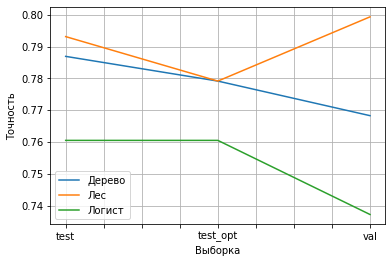

In [ ]:
# Ответы в кучку, чтобы сравнить

# Убираем длинные циферки
pd.set_option('display.float_format', '{:,.3f}'.format)

print()
print('val')
print("- Точность лучшей модели `Решающее дерево`:", result_dt_c_val)
print("- Лучшая модель:", best_model_dt_c_val)
print('test')
print("- Точность оптимизированная по лучшей валидационной модели `Решающее дерево`:", result_dt_c_test_opt)
print("- Точность лучшей модели `Решающее дерево` на тестовой выборке:", result_dt_c_test)
print("- Лучшая модель:", best_model_dt_c_test)

print()
print()
print('val')
print("- Точность лучшей  модели `Случайный лес`:", result_rf_c_val)
print("- Лучшая модель:", best_model_rf_c_val)
print('test')
print("- Точность оптимизированная по лучшей валидационной модели `Случайный лес`:", result_dt_c_test_opt)
print("- Точность лучшей модели `Случайный лес` на тестовой выборке:", result_rf_c_test)
print("- Лучшая модель:", best_model_rf_c_test)

print()
print()
print('val')
print("- Точность логистической регрессии:", result_log_r_val)
print("- Лучшее количество итераций логистической регрессии:", best_iter_log_r_val)
print('test')
print("- Точность оптимизированная по лучшей валидационной модели `Логистическая регрессия`:", result_log_r_test_opt)
print("- Точность логистической регрессии на тестовой выборке:", result_log_r_test)
print("- Лучшее количество итераций логистической регрессии:", best_iter_log_r_test)

# Кучка табличкой
final = {'Выборка': ['val', 'test_opt', 'test'],
         'Дерево': [result_dt_c_val, result_dt_c_test_opt, result_dt_c_test], 
         'Лес': [result_rf_c_val, result_dt_c_test_opt, result_rf_c_test], 
         'Логист': [result_log_r_val, result_log_r_test_opt, result_log_r_test]
         }
final = pd.DataFrame(final) 
print()
display(final)

display(pd.pivot_table(final, 
                       index=['Выборка'], 
                       values=['Дерево', 'Лес', 'Логист'])
                       .plot(kind='line', 
                             grid=True))
plt.xlabel("Выборка")
plt.ylabel("Точность")
plt.show() 

##### Вывод



*   Ранжировка точности моделей подтвердилась.
*   Точность прогноза по тестовой выборке будет несколько отличаться от валидационной.
*   Разлет точности прогноза получается в несколько процентов от расчетной величины. Например 78% плюс-минус 3%.

## 5. Дополнительное задание: 

проверьте модели на вменяемость. Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше. В следующем курсе подробнее об этом расскажем.

Понятно что надо бы проверить достоверность полученный данных. Но как это делать?

Погуглил, не понял, жду следующего курса.